This file takes in cropped satellite image of a city (here done on Seattle) and produces images chips and saves them as numpy arrays. I've used Sentinale image with a resolution of 10 meters and 'EPSG:32610 - WGS 84 / UTM zone 10N - Projected' CRS

The bands of the images are - blue, green, red, nir, ndvi

Other input is raster (.tif) with parks. It was created in qgis from vector data about the parks. It has the same resolution and crs as the satellite image

In [ ]:
#install packages
!pip install pyrsgis
!pip install rasterio
!pip install patchify
!pip install focal-loss

     |████████████████████████████████| 19.3 MB 8.5 MB/s 
     |████████████████████████████████| 462 kB 34.9 MB/s 


In [ ]:
# Connecting to the Drive if used with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import rasterio
import numpy as np
%matplotlib inline
from osgeo import gdal

# Open the file:
image = gdal.Open('link to tif image')
park = gdal.Open('link to parks in tif image')

print(image)
print(park)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff61b0f8c30> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7ff60c0f48a0> >


In [ ]:
# turn image into array
image_array = image.ReadAsArray()
print(image_array.shape)

#chaniging negative ndvi values to 0
image_array[4][image_array[4] < 0] = 0
image_array = np.transpose(image_array, [1, 2, 0]) # transpose the bands to the third dimension
print(image_array.shape)

(5, 1385, 1452)
(1385, 1452, 5)


In [ ]:
#turn park into array
park_array = park.ReadAsArray()
park_array = np.expand_dims(park_array, axis = 2)
print(park_array.shape)

(1385, 1452, 1)


In [ ]:
image_array[50][50] #pixel from the 50th row and 50th column

array([9.360000e+02, 9.000000e+02, 8.470000e+02, 2.275000e+03,
       4.573991e-01], dtype=float32)

patchify to create image patches

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#check the image array shape
image_array.shape

(1385, 1452, 5)

In [ ]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#divide all images into patches 
patch_size = 256 #size of images
step = 32 #step, stride. If smaller the size of an image we have the same location on few chips
image_dataset = []  
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(image_array, (patch_size, patch_size, 5), step=step)  #HERE ADD STRIDE
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.     
    #print(single_patch_img.shape)                    
    image_dataset.append(single_patch_img) 
    #if you want to save each patch as separate image
    #image_to_save = np.transpose(single_patch_img, [2, 0, 1]) #transpose to put bands as the first one to save the image
    #tiff.imwrite('location to save the chips' + 'image_' + str(i)+ '_' +str(j)+ ".tif", image_to_save)
    #tiff.imwrite()

image_dataset = np.array(image_dataset)
image_dataset.shape

(1368, 256, 256, 5)

In [ ]:
image_dataset[0][0][0]

array([0.09446567, 0.20483193, 0.16644235, 0.5351148 , 0.68572664],
      dtype=float32)

In [ ]:
#saving chips as numpy arrays to drive to use in later stages
np.save('location to save numpy arrays', image_dataset)

and now for parks

In [ ]:
#divide all images into patches - use the same patch size and stride as for sattelite images
park_dataset = []  
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(park_array, (patch_size, patch_size, 1), step=step)  #HERE ADD STRIDE
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.     
    #print(single_patch_img.shape)                    
    park_dataset.append(single_patch_img) 
    #park_to_save = np.transpose(single_patch_img, [2, 0, 1]) #transpose to put bands as the first one to save the image
    #tiff.imwrite('location to save the chips' + 'image_' + str(i)+ '_' +str(j)+ ".tif", park_to_save)
    #tiff.imwrite()

park_dataset = np.array(park_dataset)
park_dataset.shape

(1368, 256, 256, 1)

In [ ]:
#saving also parks chips to drive as numpy arrays
np.save('location to save numpy arrays', park_dataset)

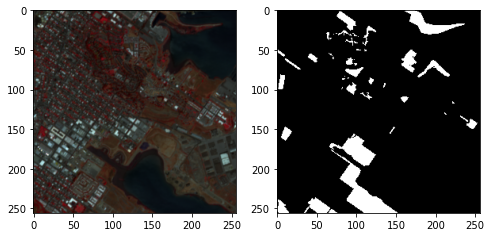

In [ ]:
# check whether the cropped images match
import random
import numpy as np
import matplotlib.pyplot as plt

# generate random number
image_number = random.randint(0, len(park_dataset)-1)
plt.figure(figsize=(8, 4))

# plot satellite image with nir (more visible then true-color) 
plt.subplot(121)
img_r = image_dataset[image_number,:,:,3]
img_g = image_dataset[image_number,:,:,2]
img_b = image_dataset[image_number,:,:,1]
img_real_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_real_col)

# plot mask
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))

Image data shape is:  (1368, 256, 256, 5)
Mask data shape is:  (1368, 256, 256, 1)
Max pixel value in image is:  1.0000001
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
